Load packages

In [2]:
library(ncdf4)
library(viridis)
library(fields)
library(rstan)
options(mc.cores = parallel::detectCores())

Set the working directory

In [3]:
setwd('d:/dropbox/working/bayesian-matrixmodel/')

Set the data processing parameters

In [4]:
ndays            <- 4.0
limit_to_numdays <- 4.0
stride_t_obs     <- 10
data             <- list()
data$dt          <- 10

Call the data processing script

In [5]:
source('data_processing.r')

Set the `i_test` vector to partition test and training

In [6]:
data$i_test = c(rep(0,round(dim(data$obs)[2]*(2/3))),rep(1,round(dim(data$obs)[2]*(1/3))))

Compile, fit, and extract the free model that has a prior

In [10]:
mod_free    <- stan_model('d:/dropbox/working/bayesian-matrixmodel/stan_code/matrixmodel_freedelta_CV.stan')

In [15]:
mcmc_free    <- sampling(mod_free,    data=data, open_progress=TRUE,chains=4)

In [16]:
post_free    <- extract(mcmc_free)

Compile, fit, and extract the original allometric model

In [8]:
mod_orig    <- stan_model('d:/dropbox/working/bayesian-matrixmodel/stan_code/matrixmodel_orig_CV.stan')

In [18]:
mcmc_orig    <- sampling(mod_orig,    data=data, open_progress=TRUE,chains=4)

In [19]:
post_orig    <- extract(mcmc_orig)

Compile, fit, and extract the sigmoidal model

In [12]:
mod_sig     <- stan_model('d:/dropbox/working/bayesian-matrixmodel/stan_code/matrixmodel_sigmoidaldelta_CV.stan')

In [20]:
mcmc_sig     <- sampling(mod_sig,     data=data, open_progress=TRUE,chains=4)

In [21]:
post_sig     <- extract(mcmc_sig)

Compile, fit, and extract the free model without a prior

In [14]:
mod_free_np <- stan_model('d:/dropbox/working/bayesian-matrixmodel/stan_code/matrixmodel_freedelta_no_prior_CV.stan')

In [23]:
mcmc_free_np <- sampling(mod_free_np, data=data, open_progress=TRUE,chains=4)

In [24]:
post_free_np <- extract(mcmc_free_np) 

Compute mean predictions

In [25]:
free_mean    <- apply(post_free$mod_obspos,c(2,3),mean)
orig_mean    <- apply(post_orig$mod_obspos,c(2,3),mean)
sig_mean     <- apply(post_sig$mod_obspos, c(2,3),mean)
free_np_mean <- apply(post_free_np$mod_obspos,c(2,3),mean) 

Compute residuals

In [26]:
free_resid    <- free_mean - data$obs
orig_resid    <- orig_mean - data$obs
sig_resid     <- sig_mean - data$obs
free_np_resid <- free_np_mean - data$obs

Generate time variable with units of minutes

In [27]:
xin <- seq(1,data$nt_obs*30,length.out=175)

Plot the residual time series for each model

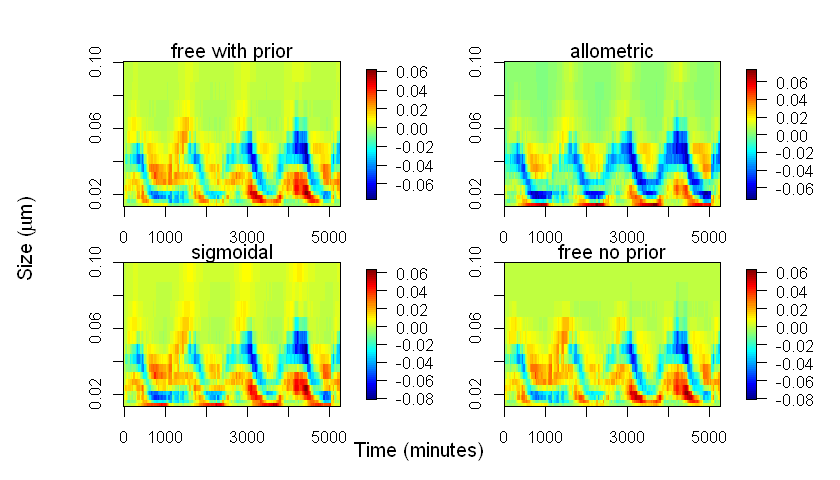

In [32]:
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow=c(2,2),mar=c(3,4,2,3),oma=c(2,2,2,2))
image.plot(x=xin,y=v,z=t(free_resid),xlab='',ylab=''); box(); mtext('free with prior')
image.plot(x=xin,y=v,z=t(orig_resid),xlab='',ylab=''); box(); mtext('allometric')
image.plot(x=xin,y=v,z=t(sig_resid),xlab='',ylab=''); box(); mtext('sigmoidal')
image.plot(x=xin,y=v,t(free_np_resid),xlab='',ylab=''); box(); mtext('free no prior')
	mtext(side=1,outer=TRUE,'Time (minutes)')
	mtext(side=2,outer=TRUE,expression('Size ('*mu*'m)'))

Plot the size-specific model-data time series agreement

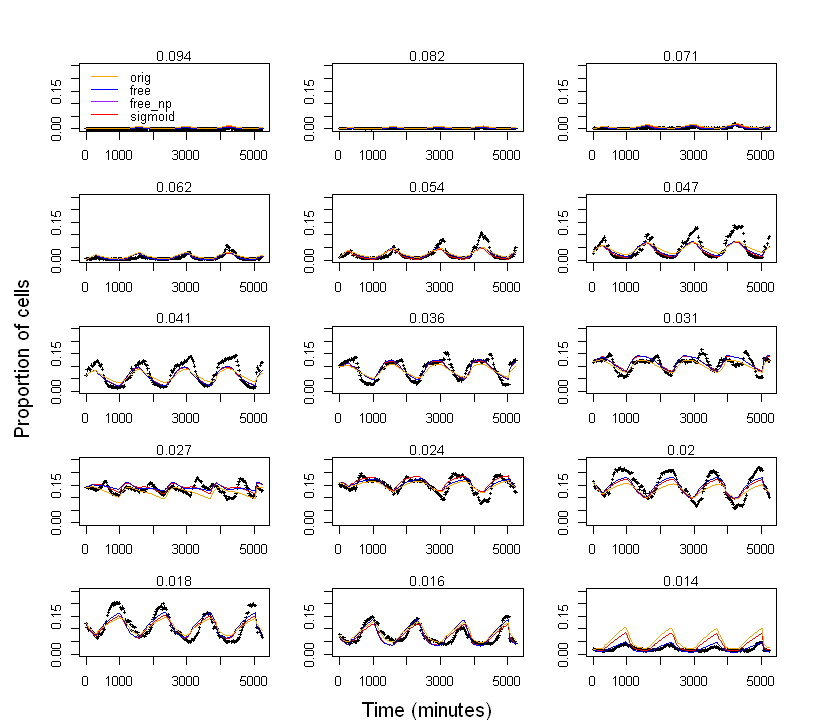

In [60]:
options(repr.plot.width=7, repr.plot.height=6)
par(mfrow=c(5,3),mar=c(2,2,2,2),oma=c(2,3,2,2))
for(i in 15:1) {
	plot(xin,data$obs[i,],ylim=c(0,0.25),cex=0.3,pch=3)
	lines(xin,sig_mean[i,],col='red',lwd=1.5)
    lines(xin,free_mean[i,],col='blue',lwd=1.5)
    lines(xin,orig_mean[i,],col='orange',lwd=1.5)
	mtext(round(v[i],3),cex=0.7)
    if(i==15){legend('topleft',bty='n',legend=c('orig','free','free_np','sigmoid'),
                    lty=1,
                    col=c('orange','blue','purple','red'))}
}
mtext(side=1,outer=TRUE,'Time (minutes)',line=1)
mtext(side=2,outer=TRUE,'Proportion of cells',line=1)

Plot the autocorrelation function of the model errors per size class

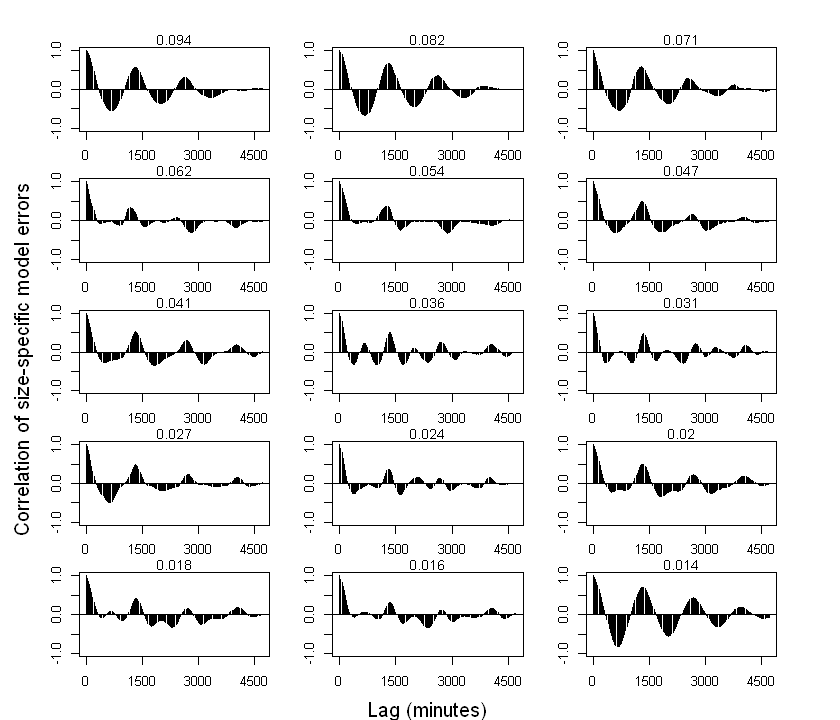

In [84]:
options(repr.plot.width=7, repr.plot.height=6)
par(mfrow=c(5,3),mar=c(2,2,1,2),oma=c(2,3,2,2))
for(i in 15:1){
	acf(sig_resid[i,],lag.max=157,main='',ylim=c(-1,1),ci=0,xaxt='n')
	axis(side=1,at=c(0,50,100,150),labels=c(0,50,100,150)*30)
	mtext(round(v[i],3),cex=0.7)
}
mtext(side=1,outer=TRUE,'Lag (minutes)',line=1)
mtext(side=2,outer=TRUE,'Correlation of size-specific model errors',line=1)

Plot the autocorrelation function of the total model error

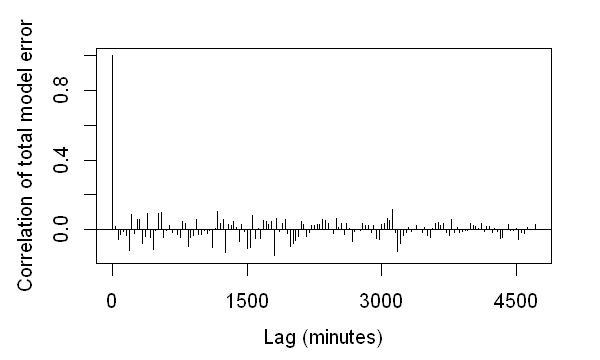

In [83]:
options(repr.plot.width=5, repr.plot.height=3)
par(mar=c(4,4,2,2))
acf(colSums(sig_resid),lag.max=157,main='',xaxt='n',xlab='',ylab='',ci=0,)
    axis(side=1,at=c(0,50,100,150),labels=c(0,50,100,150)*30)#
    mtext(side=1,'Lag (minutes)',line=2.5)
    mtext(side=2,'Correlation of total model error',line=2.5)


Plot the autocorrelation function of the model solution. 

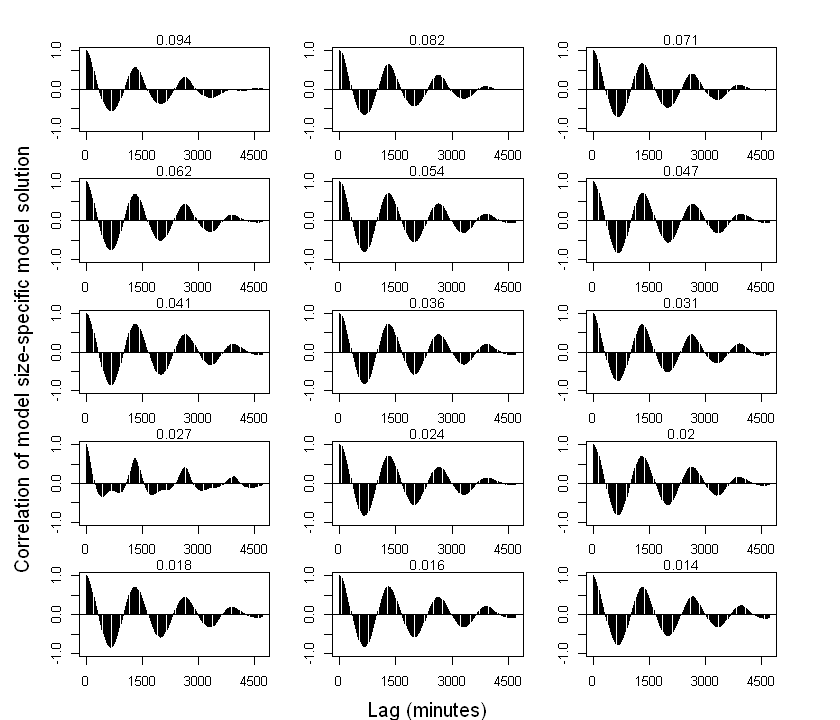

In [85]:
par(mfrow=c(5,3),mar=c(2,2,1,2),oma=c(2,3,2,2))
for(i in 15:1){
	acf(sig_mean[i,],lag.max=157,main='',ylim=c(-1,1),ci=0,xaxt='n')
	axis(side=1,at=c(0,50,100,150),labels=c(0,50,100,150)*30)
	mtext(round(v[i],3),cex=0.7)
}
mtext(side=1,outer=TRUE,'Lag (minutes)',line=1)
mtext(side=2,outer=TRUE,'Correlation of model size-specific model solution',line=1)